<a href="https://colab.research.google.com/github/Adrok24/NN_exercises/blob/master/neural_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import PIL
import IPython.display as display


In [235]:
!curl -o picasso.jpg https://cdn.shopify.com/s/files/1/1878/0085/products/diy-paint-by-number-kit-for-adults-on-canvas-psychedelic-lion-40x50cm-16x20inches_1024x1024@2x.jpg?v=1583826775

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56568  100 56568    0     0   726k      0 --:--:-- --:--:-- --:--:--  736k


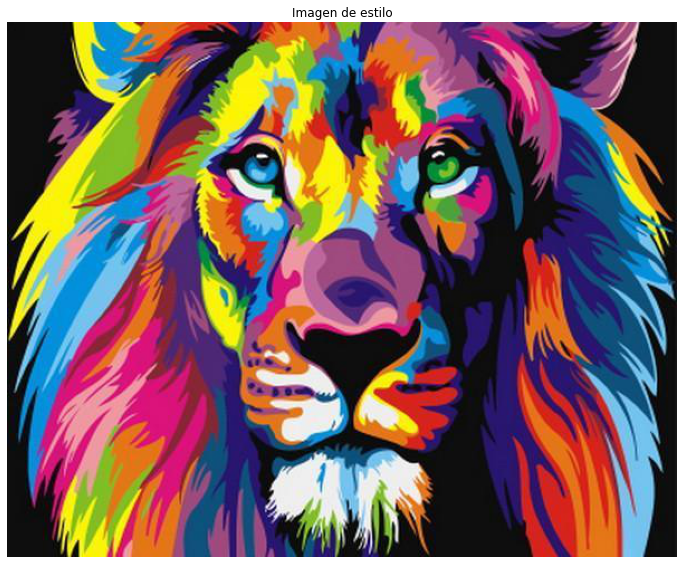

In [236]:
style_path = 'picasso.jpg'
plt.imshow(image.load_img(style_path))
plt.title('Imagen de estilo')
plt.axis('off');

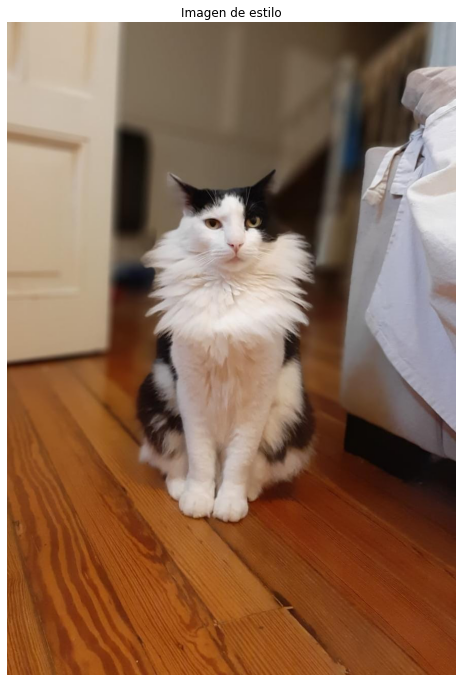

In [237]:
content_path = 'cat_2.jpeg'
plt.imshow(image.load_img(content_path))
plt.title('Imagen de estilo')
plt.axis('off');

In [238]:
# Definimos una función que convierte un tensor en una imagen 
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [239]:
# Definimos una función que carga una imagen y limita su dimensión máxima a 512 píxeles
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [240]:
from tensorflow.keras.applications import vgg19

# Este modelo será cargado con pesos pre-entrenados con ImageNet.
model = vgg19.VGG19(weights='imagenet',
                    include_top=False)

print('Modelo cargado.')

Modelo cargado.


In [241]:
# Inspeccionamos la arquitectura de la red
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Definimos las capas que utilizaremos para capturar el contenido objetivo y el estilo de referencia:

In [242]:
# Nombre de la capa usada para content loss
content_layers = ['block4_conv2']

# Nombre de la capa usada para style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Definimos una función para obtener los *outputs* de una serie de capas intermedias del modelo VGG19:

In [243]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [244]:
# Cargamos las imágenes, hacemos resizing y convertimos en tensores
content_image = load_img(content_path)
style_image = load_img(style_path)

In [245]:
# Probamos la función extrayendo los outputs de las capas de estilo
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)
style_outputs

[<tf.Tensor: shape=(1, 408, 512, 64), dtype=float32, numpy=
 array([[[[0.0000000e+00, 3.3182206e+00, 2.8329325e+00, ...,
           0.0000000e+00, 4.8889275e+00, 0.0000000e+00],
          [0.0000000e+00, 5.4610376e+00, 9.2257681e+00, ...,
           0.0000000e+00, 2.5684801e+01, 2.0268690e+01],
          [0.0000000e+00, 4.9455547e+00, 8.2267771e+00, ...,
           0.0000000e+00, 2.3099867e+01, 1.7782131e+01],
          ...,
          [0.0000000e+00, 4.5847034e+00, 6.5617628e+00, ...,
           0.0000000e+00, 1.7847622e+01, 1.0668734e+01],
          [0.0000000e+00, 5.4087462e+00, 7.2655759e+00, ...,
           0.0000000e+00, 1.9088770e+01, 1.0337554e+01],
          [0.0000000e+00, 9.5672894e+00, 1.8638592e+01, ...,
           0.0000000e+00, 5.1245483e+01, 5.0536324e+01]],
 
         [[0.0000000e+00, 3.9397645e+00, 5.4922831e-01, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [4.9310379e+00, 6.6967525e+00, 8.2408504e+00, ...,
           0.0000000e+00, 3.7943666

Definimos una función para calcular la matriz de Gram. La matriz de Gram representa un mapa de las correlaciones encontradas en una matriz de *features*:

$$ G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ} $$

donde $F^{l}_{ij}$ son las representaciones de los *features maps* de la capa convolucional $l$ para una imagen dada.

Las correlaciones entre los *features* se obtienen calculando el producto interno entre los *feature maps* vectorizados $i$ y $j$ de una determinada capa $l$. Para su cálculo, utilizamos `tf.linalg.einsum()`:

In [246]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)
    return result

Definimos ahora una clase que recibe una lista de capas de contenido y otra de estilo y devuelve un diccionario que mapea los *outputs* de las correspondientes capas:

In [247]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Espera inputs float en el rango [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

Haciendo un llamado de una instancia de la clase sobre una imagen, este modelo retorna la matriz de Gram de cada capa de estilo y el contenido de las capas de contenido.

In [248]:
extractor = StyleContentModel(style_layers, content_layers)
# Asignamos una constante para la imagen de contenido original para no modificarla
results = extractor(tf.constant(content_image))

## Descenso de gradiente

Extrayendo el estilo y el contenido, ya podemos implementar el algoritmo de *style transfer*. Lo hacemos calculando el error cuadrático medio de la imagen generada con respecto a cada *target* y luego tomando una suma ponderada de estas pérdidas.

Definimos nuestro objetivos de contenido y estilo:

In [249]:
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']

Instanciamos como una `tf.Variable` la imagen a optimizar. Para hacerlo rápido, la inicializamos con la imagen de contenido.

In [250]:
image = tf.Variable(content_image)

Como es una imagen de números `float`, definimos una función para mantener el valor de cada píxel acotado entre 0 y 1:

In [251]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Definimos un optimizador. El trabajo original recomienda el algoritmo LBFGS, pero Adam funciona bien también:

In [252]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Para optimizar la imagen generada, usamos una combinación ponderada de las pérdidas de contenido y estilo en la pérdida total: 

$$ L_{total} = \alpha L_{content} + \beta L_{style} $$

In [253]:
content_weight = 0.025
style_weight = 0.5

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Usamos `tf.GradientTape` para actualizar la imagen generada:

In [254]:
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Corremos el algoritmo unos pocos pasos para verificar que funciona correctamente:

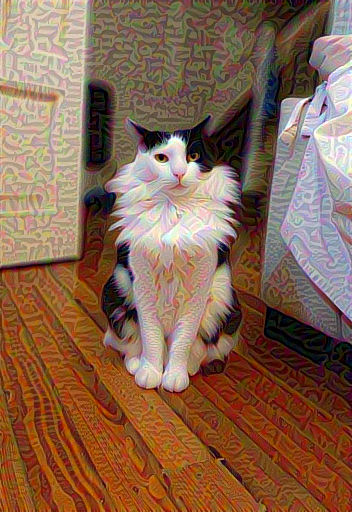

In [255]:
for i in range(5):
    train_step(image)

tensor_to_image(image)

¡Excelente! Vemos que el algoritmo funciona y que la imagen de contenido empieza a adoptar el estilo de la imagen de referencia. Ya que vamos bien encaminados, hacemos una optimización por más iteraciones:

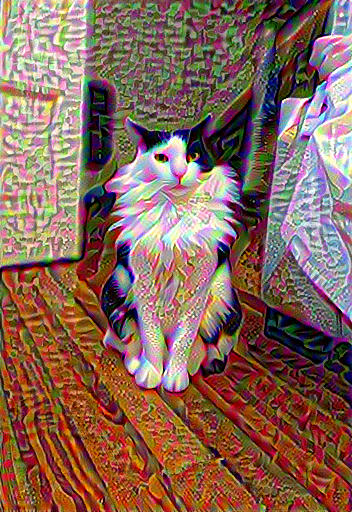

Train step: 20
Tiempo total: 177.8


In [256]:
# Éste proceso puede ser algo costoso, por lo que vamos a ir tomando los tiempos de runtime
import time
start = time.time()

epochs = 2
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
end = time.time()
print("Tiempo total: {:.1f}".format(end-start))

## Pérdida de variación total

Un problema con esta implementación básica es que produce muchos artefactos de alta frecuencia. Podemos reducir su cantidad usando un término explícito de regularización sobre los componentes de alta frecuencia de la imagen. En *style transfer*, esto se llama comúnmente **pérdida de variación total**:

In [257]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

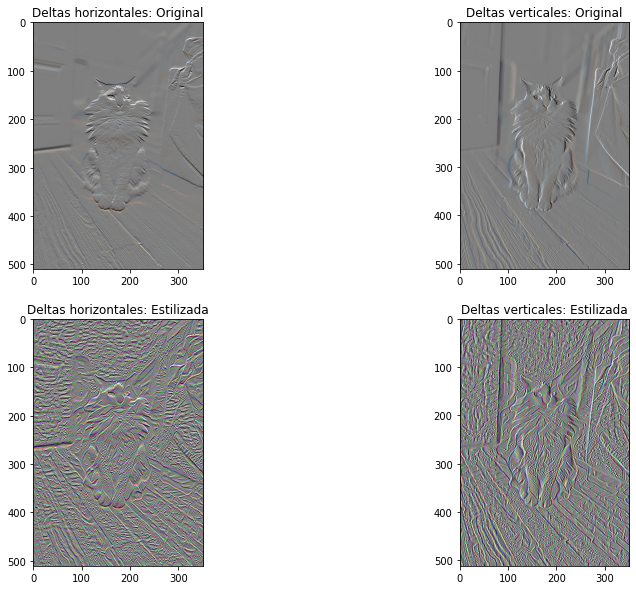

In [258]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Deltas horizontales: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Deltas verticales: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Deltas horizontales: Estilizada")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Deltas verticales: Estilizada")

Estos gráficos muestran que los comoponentes de alta frecuencia se han incrementado en la imagen estilizada.

La pérdida de regularización asociada con esto es la suma de los valores absolutos de los deltas:

In [259]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [260]:
total_variation_loss(image).numpy()

89642.766

Esto demuestra cómo se calcula la *total variation loss*. Afortunadamente, no hay necesidad de implementarla por nuestra cuenta, ya que existe una implementación propia de TensorFlow para calcularla:

In [261]:
tf.image.total_variation(image).numpy()

array([89642.766], dtype=float32)

Volvemos a correr el algoritmo de optimización, esta vez incluyendo el término de regularización y su peso respectivo: 

In [262]:
total_variation_weight = 30

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [263]:
# Reinicializamos la imagen a optimizar
image = tf.Variable(content_image)

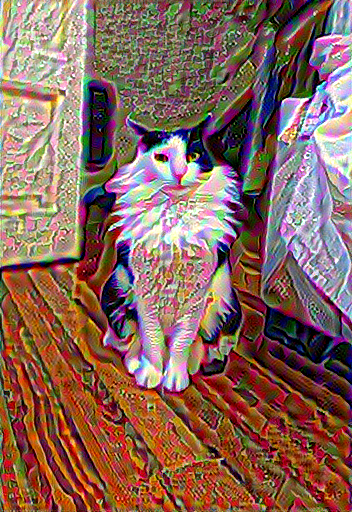

Train step: 50
Tiempo total: 443.3


In [264]:
# Este proceso puede ser algo costoso, por lo que vamos a ir tomando los tiempos de runtime
import time
start = time.time()

epochs = 5
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
end = time.time()
print("Tiempo total: {:.1f}".format(end-start))

Tengamos en cuenta que lo que esta técnica logra es meramente una forma de re-texturado de imagenes, o transferencia de textura. Funcionará mejor con imágenes de referencia de estilo con texturas notorias y auto-similares, y con imágenes de contenido que no requieren alto nivel de detalles para ser reconocibles. Típicamente, no sería posible lograr metas relativamente abstractas como "transferir el estilo de un retrato a otro".

Por último, guardamos el resultado: 

In [265]:
file_name = 'dante.jpg'
tensor_to_image(image).save(file_name)

## Fast Style Transfer

Adicionalmente, notemos que la ejecución de este algoritmo de transferencia de estilo es bastante lenta. De todos modos, la transformación con la que opera nuestro *setup* es suficientemente simple para que pueda ser aprendido también por una *convnet* feedforward rápida y pequeña.

La transferencia de estilos rápida puede conseguirse primero inviertiendo muchos ciclos de computación para generar ejemplos de entrenamiento input-output para un estilo de referencia fijo, usando el método provisto, y luego entrenando una *convnet* simple para aprender esta transformación de estilo específica. Una vez hecho esto, estilizar una nueva imagen es instantáneo: es sólo un *feedforward* de esta pequeña *convnet*.

Este *approach* es mucho más rápido (hasta 1000x). Un módulo pre-entrenado de [*Arbitrary Image Stylization*](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) está disponible en TensorFlow Hub, y también para TensorFlow Lite. Veamos cómo podemos utilizarlo con tan sólo unas pocas líneas de código:

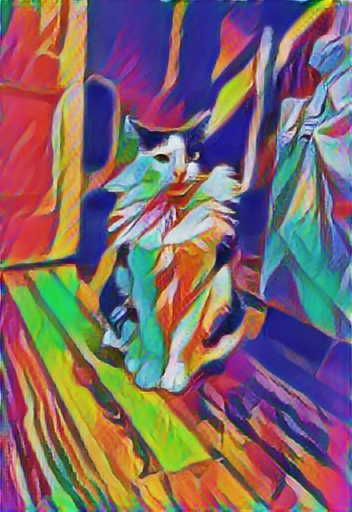

In [266]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)